In [419]:

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from decimal import Decimal
import sys




import gurobipy as gp
from gurobipy import GRB

import scipy.sparse as sp
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import figure
import numpy as np
import random 
from decimal import Decimal
from math import ceil, floor, pow
import pickle

##########################################################################################################
  
#function to count significant figures
def count_sigfigs(numstr):
    return len(Decimal(numstr).normalize().as_tuple().digits)

##########################################################################################################  
    
def prep_data3(ID, Round, Norm=False):
    ''' Drops NaN and empty columns, binarizes ALL categorical data
    
    ID    : Integer. ID of the database, taken from the UCI repository
    Norm  : Boolean. If true, features are normalized at the beggining to match max and min values
    Round : Integer. Rounds values to that many significant figures, is they need to.
    '''
    
    database = fetch_ucirepo(id=ID) 
    X = database.data.features #dataframes by default
    y = database.data.targets 

    #delete 'nan' and '?' rows
    Data = X.dropna()
    for j in range(len(Data.columns)):
        if (Data.dtypes[j].name == 'object'): 
            col_name = Data.columns[j]
            Data = Data[Data[col_name] != '?']

    Y = y.iloc[Data.index]
    Data = Data.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    if (ID==2):                                               #you need to set these ones mannually, they're all different
        y = [int(i == '>50K.') for i in Y['income']]
    elif (ID == 45):                                          #heart
        mask = Data[Data['chol'] >= 500].index
        
        Data= Data.drop(mask)      #take out outsiders
        Y = Y.drop(mask)
        
        Data = Data.reset_index(drop=True)
        Y = Y.reset_index(drop=True)
        
        y = [i for i in Y['num']]
        #y = [int(i != 0) for i in Y['num']]
        
        Data['ca'] = Data['ca'].astype(int)
        Data['thal'] = Data['thal'].astype(int)
    elif (ID==73):                                            #mushrooms
        y = [int(i == 'p') for i in Y['poisonous']]
    elif (ID==75):                                            #musk v2
        y = [int(i) for i in Y['class']] 
    elif (ID==101):                                           #tictactoe                                         
        y = [int(i == 'positive') for i in Y['class']]   
    elif (ID==144):
        y = [i-1 for i in Y['class']]



    #binarize categorical data (with more than 2 categories)
    info = database.variables
    if (ID==101)|(ID==73):
        info = info.drop(0, axis=0).reset_index()
    elif (ID==75):
        info = info.drop([0,1, 168], axis=0).reset_index()
        
    Ncols = len(info)

    categ_col_list = [info['name'][i] for i in range(Ncols) if ((info['type'][i]=='Categorical') | (info['type'][i]=='Binary'))]
    for col_name in categ_col_list: 
        print('---' + col_name +'---')

        num_uniques = len(Data[col_name].unique())
        if (num_uniques != 2):
            for value in Data[col_name].unique():
                new_col_name = 'Is ' + col_name + ' = ' + str(value)
                New_Column = pd.DataFrame([n for n in [(Data[col_name] == value).astype(int)][0]], columns=[new_col_name])
                Data = pd.concat([Data, New_Column], axis=1)
            Data = Data.drop(col_name, axis=1)
        elif (num_uniques == 2):
            
            value = Data[col_name].unique()[0]
            new_col_name = 'Is ' + col_name + ' = ' + str(value)
            New_Column = pd.DataFrame([n for n in [(Data[col_name] == value).astype(int)][0]], columns=[new_col_name])
            Data = pd.concat([Data, New_Column], axis=1)
            Data = Data.drop(col_name, axis=1)
        else:
            print('ERROR_Uniques')
    #print(Data)       
    #Scale columns to given s.f.
    
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(Data)
    
    for col in Data.columns:  
       
        if (str(Data[col].dtype)[:5]=='float'):
            precission = max([len(str(Data[col][i]).split('.')[1]) for i in range(len(Data))])
            size =  max([len(str(Data[col][i]).split('.')[0]) for i in range(len(Data))])
        elif (str(Data[col].dtype)[:3]=='int'):
            precission = 0
            size = max([len(str(Data[col][i])) for i in range(len(Data))])
        
        if (size + precission <= Round)&(precission > 0):
            New_Column = pd.DataFrame([int(i*(10**precission)) for i in Data[col]], columns=[col+ ' 10^' + str(precission)])
            Data = pd.concat([Data, New_Column], axis=1)
            Data = Data.drop(col, axis=1)
        elif (size + precission > Round):
            expon = Round - size
            New_Column = pd.DataFrame([round(i*(10**expon)) for i in Data[col]], columns=[col+ ' 10^' + str(expon)])
            Data = pd.concat([Data, New_Column], axis=1)
            Data = Data.drop(col, axis=1)
    
    
    '''#normalize if chosen
    #Keeps as many significant figures as needed to be able to un-do the normalization and not lose information 
    #(you'd need the un_norm dataframe to recover the innitial data)
    if norm:
        un_norm = pd.DataFrame()
        for i in Data.columns:
            col_max = max(Data[i])
            col_min = min(Data[i])
            col_range = col_max - col_min
            
            precis = max(count_sigfigs(str(col_range)), len(str(int(col_range))) )
            dec_places = -Decimal(str(Data[i][0])).as_tuple().exponent
            un_norm[i] = [col_range, col_min, int(precis), dec_places]
            
            Data[i] = [round( (j-col_min)/col_range, precis) for j in Data[i]]''' #skip this for now
        
    #turn it into a np array, we dont like pandas anymore :(
    data_vals = Data.to_numpy()
    data_cols = Data.columns.to_numpy()
    
    with open('Model_Script/Data/Data_vals_id_'+str(ID)+'.npy', 'wb') as f:
        np.save(f, data_vals)
    with open('Model_Script/Data/Data_cols_id_'+str(ID)+'.npy', 'wb') as f:
        np.save(f, data_cols)
    with open('Model_Script/Data/y_id_'+str(ID)+'.npy', 'wb') as f:
        np.save(f, y)
    if Norm:
        un_norm_vals =  un_norm.to_numpy()
        with open('Model_Script/Data/un_norm_vals_id_'+str(ID)+'.npy', 'wb') as f:
            np.save(f, un_norm_vals)
    
    
    # metadata & variable information 
    #print(database.metadata) 
    #print('-----------')
    #print(database.variables) 
    if Norm: 
        return data_vals,data_cols, y, un_norm_vals
    else:
        return data_vals,data_cols, y
    
################################################################################################################## 
ID = 45

Data_vals, Data_cols, yy = prep_data3(ID, 3)


---sex---
---cp---
---fbs---
---restecg---
---exang---
---slope---
---thal---


In [428]:
yy

[0,
 2,
 1,
 0,
 0,
 0,
 3,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 4,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 1,
 0,
 0,
 0,
 3,
 1,
 3,
 0,
 4,
 0,
 0,
 0,
 1,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 1,
 2,
 3,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 3,
 2,
 3,
 4,
 0,
 3,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 1,
 1,
 1,
 2,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 1,
 0,
 4,
 1,
 0,
 1,
 0,
 0,
 3,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 2,
 0,
 3,
 2,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 1,
 0,
 4,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 1,
 0,
 0,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 3,
 0,
 0,
 1,
 0,
 0,


In [400]:
Data_vals[400]

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1], dtype=int64)

In [392]:
database = fetch_ucirepo(id=101) 
X = database.data.features #dataframes by default
y = database.data.targets 

y

,class
0,positive
1,positive
2,positive
3,positive
4,positive
...,...
953,negative
954,negative
955,negative
956,negative


In [396]:
X['bottom-right-square']

0      o
1      o
2      x
3      b
4      b
      ..
953    x
954    x
955    x
956    x
957    x
Name: bottom-right-square, Length: 958, dtype: object

In [367]:
X['f7'].unique()

array([  38,   57,   27,   26,   20,   32,   37,   42,   41,   19,   40,
         56,   30,   28,   31,   25,   66,   35,   43,   53,   54,   52,
         49,   48,   44,   59,   24,   51,   50,   73,  151,  150,  152,
         60,  186,   74,  153,   61,   62,  172,   36,    7,    5,    6,
          4,   29,   11,    9,   21,   33,   10,   -8,   67, -164, -160,
         68, -165, -161, -162,  -13,  -15,  -20, -159,   18,  -12,  -17,
        -11,  207,  208,  190,   81,  193,   83, -158, -163,  210,  211,
        188,   80,   86,  198,  200,  199,  209, -166,  -22,  -26,  116,
        111,   98,   93,  -51, -150,   55,   58, -154, -125, -167, -155,
       -136, -168,   63, -132, -153,   65,   45,   75,   77,   69,   64,
         71,   46,   90,  138,  136,  178,   85,   92,   84,   34,  183,
         78,   47,   76,   79,   70,  -30,  -53,   72,  -64,  -61,  -52,
        -54,  -65,  -62,  -55, -169, -156, -149, -126, -157, -127, -148,
       -144, -145,  -67,   39,  -32,   17,  -31,   

In [397]:
database.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,top-left-square,Feature,Categorical,None,None,None,no
2,top-middle-square,Feature,Categorical,None,None,None,no
3,top-right-square,Feature,Categorical,None,None,None,no
4,middle-left-square,Feature,Categorical,None,None,None,no
5,middle-middle-square,Feature,Categorical,None,None,None,no
6,middle-right-square,Feature,Categorical,None,None,None,no
7,bottom-left-square,Feature,Categorical,None,None,None,no
8,bottom-middle-square,Feature,Categorical,None,None,None,no
9,bottom-right-square,Feature,Categorical,None,None,None,no


In [389]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def MAX_group_ineq(Data_vals, y, vvars, Prot_feats, E=1):
    '''finds max Delta y(I)'''
    N = len(y)
    E_behav = E
    
    Y_pos_index = np.array([i for i in range(N)])[[(i==1) for i in y]]
    Y_neg_index = np.array([i for i in range(N)])[[(i==0) for i in y]]

    Prot_feats_SetList = []
    for feat in Prot_feats:
        #get I_f^k 's
        Prot_feats_SetList += [np.array([i for i in range(N)])[[ i[feat]==1  for i in Data_vals]]] #assuming the feature is binary, f_1
        Prot_feats_SetList += [np.array([i for i in range(N)])[[ i[feat]==0  for i in Data_vals]]] #f_2

    if Prot_feats: #if we include fairness constraints in the model
        #get P_f^k 's
        Pfks = []
        for setlist in Prot_feats_SetList:
            Pfks += [intersection( Y_pos_index , setlist )]
        if (E_behav==1):
            #get N_f^k 's
            Nfks = []
            for setlist in Prot_feats_SetList:
                Nfks += [intersection( Y_neg_index , setlist )]
    
    cs=[]
    for var in vvars:
        if str(var[0])[0]=='c':
            cs+=[var]
            
    maxxFP = 0
    maxxFN = 0
    
    for feat in range(len(Prot_feats)):
        print(sum(int(cs[i][1][0]) for i in Pfks[2*feat]   )/len(Pfks[2*feat]))
        print(sum(int(cs[i][1][0]) for i in Pfks[2*feat+1]   )/len(Pfks[2*feat+1]))
        curr = abs(sum(int(cs[i][1][0]) for i in Pfks[2*feat]   )/len(Pfks[2*feat])   -  sum(int(cs[i][1][0]) for i in Pfks[2*feat+1] )/len(Pfks[2*feat+1]))
        if curr>maxxFP:
            maxxFP=curr
            
        if E_behav==1:
            print(sum(int(cs[i][1][0]) for i in Nfks[2*feat]   )/len(Nfks[2*feat]))
            print(sum(int(cs[i][1][0]) for i in Nfks[2*feat+1]   )/len(Nfks[2*feat+1]))
            curr2 = abs(sum(int(cs[i][1][0]) for i in Nfks[2*feat]   )/len(Nfks[2*feat])   -  sum(int(cs[i][1][0]) for i in Nfks[2*feat+1] )/len(Nfks[2*feat+1]))
            if curr2>maxxFN:
                maxxFN=curr2
                
                
    return maxxFP, maxxFN

######################################################################################################################

prot_feats = [1]
with open('Model_script/Results/Vars_N296_A6_Clas1_B0 simple_F1.npy', 'rb') as f:
        vvars1 = np.load(f,allow_pickle=True)
with open('Model_script/Results/Vars_N296_A6_Clas1_B0 simple_F1_Fair0_bd10.05.npy', 'rb') as f:
        vvars2 = np.load(f,allow_pickle=True)
with open('Model_script/Results/Vars_N296_A6_Clas1_B0 simple_F1_Fair1_bd10.05.npy', 'rb') as f:
        vvars3 = np.load(f,allow_pickle=True)
        
with open('Data_vals_id_'+str(45)+'.npy', 'rb') as f:
        Data_vals = np.load(f,allow_pickle=True)
with open('y_id_'+str(45)+'.npy', 'rb') as f:
        y = np.load(f,allow_pickle=True)

print(MAX_group_ineq(Data_vals, y, vvars1, prot_feats))
print('-------------------------')
print(MAX_group_ineq(Data_vals, y, vvars2, prot_feats, E=1))
print('-------------------------')
print(MAX_group_ineq(Data_vals, y, vvars3, prot_feats, E=1))


0.10714285714285714
0.36
0.24719101123595505
0.0
(0.25285714285714284, 0.24719101123595505)
-------------------------
0.13392857142857142
0.16
0.2808988764044944
0.08571428571428572
(0.02607142857142858, 0.1951845906902087)
-------------------------
0.24107142857142858
0.2
0.11235955056179775
0.07142857142857142
(0.041071428571428564, 0.040930979133226325)


In [40]:
ID = 45
database = fetch_ucirepo(id=ID) 
X = database.data.features #dataframes by default
y = database.data.targets 

#delete 'nan' and '?' rows
Data = X.dropna()
for j in range(len(Data.columns)):
    if (Data.dtypes[j].name == 'object'): 
        col_name = Data.columns[j]
        Data = Data[Data[col_name] != '?']

Y = y.iloc[Data.index]
Data = Data.reset_index(drop=True)
Y = Y.reset_index(drop=True)

if (ID==2):                                               #you need to set these ones mannually, they're all different
    y = [int(i == '>50K.') for i in Y['income']]
elif (ID == 45):
    mask = Data[Data['chol'] >= 500].index

    Data= Data.drop(mask)      #take out outsiders
    Y = Y.drop(mask)

    Data = Data.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    #y = [i for i in Y['num']]
    y = [int(i != 0) for i in Y['num']]

    Data['ca'] = Data['ca'].astype(int)
    Data['thal'] = Data['thal'].astype(int)

elif (ID==144):
    y = [i-1 for i in Y['class']]

In [152]:
Data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,57,0,4,140,241,0,0,123,1,0.2,2,0,7
292,45,1,1,110,264,0,0,132,0,1.2,2,0,7
293,68,1,4,144,193,1,0,141,0,3.4,2,2,7
294,57,1,4,130,131,0,0,115,1,1.2,2,1,7


In [373]:
with open('Model_script/Results/Ruleset_N296_A6_Clas1_B0 simple_F3.npy', 'rb') as f:
        print(np.load(f,allow_pickle=True))


((oldpeak 10^1>=25.0))  |  ((chol>=267.0)&(oldpeak 10^1>=15.1))  |  ((Is sex = 1>=0.1)&(ca>=0.1))  |  ((thalach<=114.0))


In [414]:
tobj=[]
for budgt in range(100,301,50):
    name_of_file = 'TimeObj_N296_A5_Clas1_B'+str(budgt)+' simple_F3'
    with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
        tobj += [np.load(f,allow_pickle=True)]

tobj2=[]        
for budgt in range(100,301,50):
    name_of_file = 'TimeObj_N296_A5_Clas1_B'+str(budgt)+' complex_F3'
    with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
        tobj2 += [np.load(f,allow_pickle=True)]
        
tobj  

[array([1802.60500002,  237.        ]),
 array([1800.73500013,  237.        ]),
 array([1800.39399981,  233.        ]),
 array([1800.04099989,  231.        ]),
 array([1802.24500012,  241.        ])]

In [415]:
tobj2

[array([1802.71899986,  233.        ]),
 array([1800.67499995,  236.        ]),
 array([1801.56200004,  244.        ]),
 array([1800.69300008,  234.        ]),
 array([1800.2329998,  243.       ])]

In [417]:
rsets=[]
for budgt in range(100,301,50):
    name_of_file = 'Ruleset_N296_A5_Clas1_B'+str(budgt)+' simple_F3'
    with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
        rsets += [np.load(f,allow_pickle=True)]

rsets2=[]      
for budgt in range(100,301,50):
    name_of_file = 'Ruleset_N296_A5_Clas1_B'+str(budgt)+' complex_F3'
    with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
        rsets2 += [np.load(f,allow_pickle=True)]
        
rsets

[array('((Is sex = 1>=0.1)&(Is cp = 4>=0.1))  |  ((Is cp = 1<=0.9)&(age>=41.1)&(oldpeak 10^1>=16.1))',
       dtype='<U92'),
 array('((age>=77.0))  |  ((trestbps>=108.1)&(Is cp = 1<=0.0)&(chol>=131.0)&(Is thal = 3<=0.0))',
       dtype='<U87'),
 array('((Is cp = 1>=0.1)&(Is restecg = 0>=0.1)&(trestbps<=134.9))  |  ((thalach<=177.0)&(Is cp = 4>=1.0))',
       dtype='<U98'),
 array('((thalach<=103.0)&(chol>=178.1))  |  ((trestbps>=178.1))  |  ((oldpeak 10^1>=19.1))  |  ((Is cp = 4>=0.1))',
       dtype='<U106'),
 array('((thalach<=150.0)&(Is thal = 3<=0.0))  |  ((oldpeak 10^1>=24.1))  |  ((Is cp = 4>=0.1)&(thalach<=177.0))',
       dtype='<U104')]

In [ ]:
(Is cp = 4>=0.1)&(Is thal = 3<=0.1))  |  ((oldpeak 10^1>=25.0)&(Is slope = 3<=0.9))  |  ((thalach<=112.0))'

In [418]:
rsets2

[array('((trestbps>=178.1))  |  ((Is slope = 3<=0.0)&(oldpeak 10^1>=20.0))  |  ((Is cp = 4>=0.1))',
       dtype='<U89'),
 array('((Is cp = 4>=1.0)&(trestbps>=142.1))  |  ((ca>=0.1)&(Is cp = 4>=0.1))  |  ((ca>=2.1))',
       dtype='<U85'),
 array('((Is cp = 4>=0.1)&(Is thal = 3<=0.1))  |  ((oldpeak 10^1>=25.0)&(Is slope = 3<=0.9))  |  ((thalach<=112.0))',
       dtype='<U107'),
 array('((trestbps>=180.0))  |  ((ca>=0.1)&(Is slope = 1<=0.0))  |  ((Is cp = 4>=0.1))',
       dtype='<U78'),
 array('((Is cp = 1<=0.0)&(Is thal = 3<=0.0))  |  ((oldpeak 10^1>=35.1))  |  ((thalach<=136.9)&(Is sex = 1>=0.1))',
       dtype='<U105')]

In [310]:

for alpha in [2,3,4,6,7]:
    name_of_file = '_N296_A'+str(alpha)+'_Clas1_B0 simple_F3'
    with open('Model_Script/Results/Ruleset' + name_of_file +'.npy', 'rb') as f:
        print(np.load(f,allow_pickle=True))
    with open('Model_Script/Results/TimeObj' + name_of_file +'.npy', 'rb') as f:
        print(np.load(f,allow_pickle=True))
        



((Is thal = 3<=0.0)&(Is cp = 1<=0.0))
[180.14700007 231.        ]
((Is thal = 3<=0.0))  |  ((thalach<=110.9))  |  ((oldpeak 10^1>=25.0))
[180.04699993 236.        ]
((Is cp = 4>=0.1)&(Is thal = 3<=0.0))  |  ((thalach<=120.9))
[600.49600005 237.        ]
((oldpeak 10^1>=25.0))  |  ((chol>=241.0)&(Is thal = 3<=0.0))  |  ((Is cp = 4>=0.1)&(ca>=0.1))  |  ((thalach<=90.0))
[3601.21000004  254.        ]
((Is slope = 1<=0.0)&(Is thal = 7>=1.0))  |  ((ca>=2.1))  |  ((oldpeak 10^1>=26.1))  |  ((Is cp = 3<=0.0)&(age<=67.0)&(ca>=1.0))
[7204.19400001  253.        ]


In [381]:
name_of_file = 'Vars_N296_A6_Clas1_B0 simple_F1_Fair1_bd10.05'

with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
    variablles = np.load(f,allow_pickle=True)
classifications = [[   int(i[0].split('[')[1].split(']')[0]), int(i[1].split('.')[0])] for i in variablles if str(i[0][0])=='c']
classifications

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 1],
 [4, 0],
 [5, 0],
 [6, 0],
 [7, 1],
 [8, 0],
 [9, 0],
 [10, 0],
 [11, 0],
 [12, 0],
 [13, 0],
 [14, 0],
 [15, 0],
 [16, 1],
 [17, 0],
 [18, 0],
 [19, 0],
 [20, 0],
 [21, 0],
 [22, 1],
 [23, 0],
 [24, 0],
 [25, 0],
 [26, 0],
 [27, 1],
 [28, 0],
 [29, 0],
 [30, 0],
 [31, 0],
 [32, 1],
 [33, 0],
 [34, 0],
 [35, 0],
 [36, 0],
 [37, 0],
 [38, 0],
 [39, 0],
 [40, 0],
 [41, 0],
 [42, 0],
 [43, 0],
 [44, 1],
 [45, 0],
 [46, 0],
 [47, 0],
 [48, 0],
 [49, 0],
 [50, 0],
 [51, 0],
 [52, 1],
 [53, 0],
 [54, 0],
 [55, 0],
 [56, 0],
 [57, 1],
 [58, 0],
 [59, 0],
 [60, 0],
 [61, 0],
 [62, 0],
 [63, 0],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 0],
 [68, 0],
 [69, 0],
 [70, 0],
 [71, 0],
 [72, 0],
 [73, 1],
 [74, 1],
 [75, 0],
 [76, 0],
 [77, 0],
 [78, 0],
 [79, 0],
 [80, 1],
 [81, 0],
 [82, 0],
 [83, 1],
 [84, 0],
 [85, 0],
 [86, 0],
 [87, 0],
 [88, 0],
 [89, 0],
 [90, 0],
 [91, 1],
 [92, 0],
 [93, 0],
 [94, 0],
 [95, 0],
 [96, 0],
 [97, 0],
 [98, 0],
 [99, 0],
 [100, 0],

In [380]:
def classified(i):
    return (((Data['ca'][i]>=0.1)&(Data['trestbps'][i]>=118.1)&(Data['thal'][i]!= 3))  |  ((Data['oldpeak'][i]>=2.41))  |  ((Data['exang' ][i]!=0)&(Data['cp'][i]==4))) 

[int(classified(i)) for i in range(N)]

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,


In [382]:
cnter = 0
for i in range(N):
    if int(classified(i))==y[i]:
        cnter+=1
        print(i, int(classified(i)), y[i], '<--', classifications[i][1])
    else: 
        print(i, int(classified(i)), y[i], '   ', classifications[i][1])
    
print(cnter)

0 0 0 <-- 0
1 1 1 <-- 0
2 1 1 <-- 0
3 1 0     1
4 0 0 <-- 0
5 0 0 <-- 0
6 1 1 <-- 0
7 1 0     1
8 1 1 <-- 0
9 1 1 <-- 0
10 0 0 <-- 0
11 0 0 <-- 0
12 1 1 <-- 0
13 0 0 <-- 0
14 0 0 <-- 0
15 0 0 <-- 0
16 0 1     1
17 0 0 <-- 0
18 0 0 <-- 0
19 0 0 <-- 0
20 0 0 <-- 0
21 0 0 <-- 0
22 0 1     1
23 1 1 <-- 0
24 1 1 <-- 0
25 0 0 <-- 0
26 0 0 <-- 0
27 1 0     1
28 0 0 <-- 0
29 1 1 <-- 0
30 0 0 <-- 0
31 1 1 <-- 0
32 0 1     1
33 0 0 <-- 0
34 0 0 <-- 0
35 0 0 <-- 0
36 1 1 <-- 0
37 1 1 <-- 0
38 1 1 <-- 0
39 0 0 <-- 0
40 1 1 <-- 0
41 0 0 <-- 0
42 0 0 <-- 0
43 0 0 <-- 0
44 0 1     1
45 1 1 <-- 0
46 0 0 <-- 0
47 1 1 <-- 0
48 0 0 <-- 0
49 0 0 <-- 0
50 0 0 <-- 0
51 0 0 <-- 0
52 0 1     1
53 0 0 <-- 0
54 1 1 <-- 0
55 1 1 <-- 0
56 1 1 <-- 0
57 0 1     1
58 0 0 <-- 0
59 0 0 <-- 0
60 1 1 <-- 0
61 0 0 <-- 0
62 1 1 <-- 0
63 0 0 <-- 0
64 1 1 <-- 0
65 1 1 <-- 0
66 1 1 <-- 0
67 0 0 <-- 0
68 1 1 <-- 0
69 1 1 <-- 0
70 0 0 <-- 0
71 1 1 <-- 0
72 1 1 <-- 0
73 0 1     1
74 0 1     1
75 0 0 <-- 0
76 1 1 <-- 0
77 0 0 <-

In [182]:
Data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,57,0,4,140,241,0,0,123,1,0.2,2,0,7
292,45,1,1,110,264,0,0,132,0,1.2,2,0,7
293,68,1,4,144,193,1,0,141,0,3.4,2,2,7
294,57,1,4,130,131,0,0,115,1,1.2,2,1,7


In [246]:
#True Positives
TP = Data[[  ( ((Data['thal'][i]!=3)&(Data['cp'][i]!=1))  &  (y[i]==1)  ) for i in range(N)]]
print(TP)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
2     67    1   4       120   229    0        2      129      1      2.6   
8     63    1   4       130   254    0        2      147      0      1.4   
9     53    1   4       140   203    1        2      155      1      3.1   
12    56    1   3       130   256    1        2      142      1      0.6   
16    48    1   2       110   229    0        0      168      0      1.0   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
287   63    1   4       140   187    0        2      144      1      4.0   
290   59    1   4       164   176    1        2       90      0      1.0   
291   57    0   4       140   241    0        0      123      1      0.2   
293   68    1   4       144   193    1        0      141      0      3.4   
294   57    1   4       130   131    0        0      115      1      1.2   

     slope  ca  thal  
2        2   2     7  
8        2   1     7  
9        3   0    

In [247]:
#True Negatives
TN = Data[[(   ( (((Data['thal'][i]!=3)&(Data['cp'][i]!=1)))==False)  &  (y[i]==0)  )for i in range(N)]]
print(TN)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
5     56    1   2       120   236    0        0      178      0      0.8   
7     57    0   4       120   354    0        0      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
276   47    1   3       130   253    0        0      179      0      0.0   
278   35    1   2       122   192    0        0      174      0      0.0   
283   56    1   2       120   240    0        0      169      0      0.0   
285   55    0   2       132   342    0        0      166      0      1.2   
289   41    1   2       120   157    0        0      182      0      0.0   

     slope  ca  thal  
0        3   0     6  
3        3   0     3  
4        1   0    

In [248]:
print(len(TP)+len(TN))

231


In [139]:
len([i  for i in range(len(y)) if y[i]==0 ])

159

In [ ]:

IDD=45
with open('Data_vals_id_'+str(IDD)+'.npy', 'rb') as f:
    Data_vals = np.load(f,allow_pickle=True)
with open('Data_cols_id_'+str(IDD)+'.npy', 'rb') as f:
    Data_cols = np.load(f,allow_pickle=True)
with open('y_id_'+str(IDD)+'.npy', 'rb') as f:
    y = np.load(f,allow_pickle=True)
with open('un_norm_vals_id_'+str(IDD)+'.npy', 'rb') as f:
    un_norm_vals = np.load(f,allow_pickle=True)

In [ ]:
#Comment in case we dont need to import the packages
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random 
#import sys #I hope we can use the sys package, because otherwise this doesnt work


def Get_costs(ID, C_behav):     
    if (ID==45):
        #        age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope,  ca, thal
        Costs =   [0,   0, 71,       20,    5,  30,      73,      10,    75,      72,    77, 100,   40] #ID = 45
            
        if (C_behav=='simple'):
            Bundles = []
        elif (C_behav=='complex'):
            Bundles = [0,0,  1,       2,    3,   2,       1,       4,     1,       1,     1,   5,    2]
        else: 
            print('you spelled something wrong in C_behav')
            
        return Costs, Bundles
    
    #do the other IDs later      
        
##################################################################################################################

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

##################################################################################################################

def Model_model(Data_vals, Data_cols, y, alpha, ID=-1, Budget = 0, M_behav = 'same', C_behav = 'simple', Un_norm = np.array([]) , focus = 0, E_behav = 0, Prot_feats = [], Eq_Bd=0.05 ):
    ''' Creates the MIP, optimizes it and gives you the resulting ruleset.
    ----------------
    Data_vals: Array with X data values
    
    Data_cols: Column names for X
    
    y:       List with obj data
    
    alpha:   Maximum number of bounds allowed
    
    ID:      The database id
    
    Budget:  Maximum budget allowed
    
    M_behav: same       --> M is computed at the begining (making it very large) and all Ms are the same
             diff       --> M is computed per feature depending on a_j (option disabled)
             
    c_behav: simple     --> Each feature has independent costs
             complex    --> Some features get discounted if selected together
             
    Un_norm: array outputed by the data prep function if you decide to normalize data; needed to turn it back to original scale
    
    focus:   Changes the MIPfocus, from 0 to 3, each modifies the branch&cut strategy for Gurobi. 

    E_behav   : 0  --> Equality of opportunity
                1  --> Equality of opportunity and Equalized odds

    Prot_feats: Protected features, as a list of column indexes, assume features are binary (sex=1 for ID=45, try that first)

    Eq_Bd     : Max vialation of classifier, for the equality constraints
    -----------------
    Outputs: 
    The model variables that encode the bounds (a, b, s), the rectangles (r), and maybe more if you want
    The ruleset as a code-ready string 
    The time it took and the objective it reached'''
    
    print('begin')
    #define some parameters
    N = len(Data_vals)    #number of points
    d = len(Data_cols)    #number of features
    m = 2*alpha +1        #small m for the inequality-related indicators
    Upsi = max(y)         #Number of classes

    if (Budget != 0):
        if (ID == -1):
            Costs = [1]*d
        else:
            Costs, Bundles = Get_costs(ID, C_behav)

    if (M_behav == 'same'):
        M= 2*Data_vals.max() + 2      
    
    Data_vals = np.asfarray(Data_vals) #Change all columns to float and find the precision of each column   
     
    e = []
    for i in range(len(Data_cols)):
        buffer = []
        for j in range(len(Data_vals)):
            buffer += [len(str(Data_vals[j][i]).split('.')[1])]
        e+=[10**-(max(buffer)+1)]
   
        
    #separate indices of y= 1s and 0s 
    if (Upsi==1):
        Y_pos_index = np.array([i for i in range(N)])[[(i==1) for i in y]]
        Y_neg_index = np.array([i for i in range(N)])[[(i==0) for i in y]]

        Prot_feats_SetList = []
        for feat in Prot_feats:
            #get I_f^k 's
            Prot_feats_SetList += [np.array([i for i in range(N)])[[ i[feat]==1  for i in Data_vals]]] #assuming the feature is binary, f_1
            Prot_feats_SetList += [np.array([i for i in range(N)])[[ i[feat]==0  for i in Data_vals]]] #f_2

        if Prot_feats: #if we include fairness constraints in the model
            #get P_f^k 's
            Pfks = []
            for setlist in Prot_feats_SetList:
                Pfks += [intersection( Y_pos_index , setlist )]
            if (E_behav==1):
                #get N_f^k 's
                Nfks = []
                for setlist in Prot_feats_SetList:
                    Nfks += [intersection( Y_neg_index , setlist )]
    elif (Upsi>=2):
        Y_pos_index = np.array([i for i in range(N)])[[(i>=1) for i in y]]
        Y_neg_index = np.array([i for i in range(N)])[[(i==0) for i in y]]

        Pos_Classes = []
        for val in range(Upsi):
            Pos_Classes += [[val, np.array([i for i in range(N)])[[(i==val+1) for i in y]]]]
        print(Pos_Classes)


    print('creating vars')
    #create the model
    Model_1 = gp.Model('model1')

    b = Model_1.addMVar((alpha), lb=0, ub=[float('inf')]*alpha, vtype=GRB.CONTINUOUS, name='b')    #b_(bnd)
    a = Model_1.addMVar((alpha,d), vtype=GRB.BINARY, name='a')                                     #a_(bnd, dim)
    s = Model_1.addMVar((alpha), vtype=GRB.BINARY, name='s')                                       #s_(bnd)
    z = Model_1.addMVar((N, alpha), vtype=GRB.BINARY, name='z')                                    #z_(point, bnd)
    r = Model_1.addMVar((alpha, alpha), vtype=GRB.BINARY, name='r')                                #r_(rec, bnd)
    w = Model_1.addMVar((N, alpha), vtype=GRB.BINARY, name='w')                                    #w_(point, rec)
    h = Model_1.addMVar((N, alpha, alpha), vtype=GRB.BINARY, name='h')                             #h_(point, rec, bnd)
    g = Model_1.addMVar((alpha), vtype=GRB.BINARY, name='g')                                       #g_(rec)
    c = Model_1.addMVar((N), vtype=GRB.BINARY, name='c')                                           #c_(point)

    
    #Model_1.addConstrs( (b[j] == 0.5 for j in range(alpha)), name='false_b_con')

    
    Model_1.addConstrs( (sum(a[j]) == 1 for j in range(alpha)), name='a_con')

    Model_1.addConstrs( (sum([r[l][j] for l in range(alpha)]) <= 1 for j in range(alpha)), name='r_con1')

    Model_1.addConstrs( (r[l][j]       >= h[i][l][j]           for i in range(N) for j in range(alpha) for l in range(alpha)), name='h_con1')
    Model_1.addConstrs( (z[i][j]       >= h[i][l][j]           for i in range(N) for j in range(alpha) for l in range(alpha)), name='h_con2')
    Model_1.addConstrs( (h[i][l][j] +1 >= r[l][j] + z[i][j]    for i in range(N) for j in range(alpha) for l in range(alpha)), name='h_con3')

    Model_1.addConstrs( (sum(r[l]) <= g[l]*alpha   for l in range(alpha)), name='g_conr')
    Model_1.addConstrs( (sum(r[l]) >= g[l]         for l in range(alpha)), name='g_conl')

    Model_1.addConstrs( (g[l] >= w[i][l]           for i in Y_neg_index for l in range(alpha)), name='w_con1')
    Model_1.addConstrs( (g[l] >= 1-w[i][l]         for i in Y_pos_index for l in range(alpha)), name='w_con1')
    
    Model_1.addConstrs( (sum(r[l])-sum(h[i][l]) >= w[i][l]           - m*(1-g[l])   for i in Y_pos_index for l in range(alpha)), name='w_con2l')
    Model_1.addConstrs( (sum(r[l])-sum(h[i][l]) <= w[i][l]*alpha     + m*(1-g[l])   for i in Y_pos_index for l in range(alpha)), name='w_con2r')
    Model_1.addConstrs( (sum(h[i][l])           >= (1-w[i][l])       - m*(1-g[l])   for i in Y_neg_index for l in range(alpha)), name='w_con3l')
    Model_1.addConstrs( (sum(h[i][l])           <= (1-w[i][l])*alpha + m*(1-g[l])   for i in Y_neg_index for l in range(alpha)), name='w_con3r')
    
    Model_1.addConstrs( (sum(w[i])         <= alpha*c[i]       for i in Y_neg_index ), name='c_con2r')
    Model_1.addConstrs( (sum(w[i])         >= c[i]             for i in Y_neg_index ), name='c_con2l')

    if (Upsi>=2):
        colors = Model_1.addMVar((alpha,Upsi), vtype=GRB.BINARY, name='color')                     #colors_(rec, col)
        zet    = Model_1.addMVar((N,alpha), vtype=GRB.BINARY, name='zet')                          #zet_(pnt, rec)

        Model_1.addConstrs( (sum(colors[l]) == 1 for l in range(alpha)), name='color_con')

        for clas in range(Upsi): #index is -1 from label
            curr_class = Pos_Classes[clas][1]
            curr_col   = Pos_Classes[clas][0]
            Model_1.addConstrs( (1-w[i][l]           >= 1 - zet[i][l]                   for i in curr_class for l in range(alpha)), name='zet_con1')
            Model_1.addConstrs( (colors[l][curr_col] >= 1 - zet[i][l]                   for i in curr_class for l in range(alpha)), name='zet_con2')
            Model_1.addConstrs( (2 - zet[i][l]       >= 1-w[i][l] + colors[l][curr_col] for i in curr_class for l in range(alpha)), name='zet_con3')

        Model_1.addConstrs( (alpha - sum(zet[i]) <= alpha*(1-c[i])   for i in Y_pos_index ), name='c_con1r')
        Model_1.addConstrs( (alpha - sum(zet[i]) >= 1-c[i]           for i in Y_pos_index ), name='c_con1l')

    elif (Upsi==1):
        Model_1.addConstrs( (alpha - sum(w[i]) <= alpha*(1-c[i])   for i in Y_pos_index ), name='c_con1r')
        Model_1.addConstrs( (alpha - sum(w[i]) >= 1-c[i]           for i in Y_pos_index ), name='c_con1l')
    
    
    if (M_behav=='same'):
        #                     b   -  ...M(1-z)... -  ...2M(s)... +          ........e........           <=         ............ax............
        Model_1.addConstrs( (b[j] - M*(1-z[i][j]) - 2*M*(s[j])   + sum(a[j][k]*e[k] for k in range(d))  <= sum(a[j][k]*Data_vals[i][k] for k in range(d))        for i in Y_neg_index for j in range(alpha)), name='z_con1l')
        Model_1.addConstrs( (b[j] - M*z[i][j]     - 2*M*(1-s[j])                                        <= sum(a[j][k]*Data_vals[i][k] for k in range(d))        for i in Y_neg_index for j in range(alpha)), name='z_con2l')
        Model_1.addConstrs( (b[j] - M*z[i][j]     - 2*M*(s[j])   + sum(a[j][k]*e[k] for k in range(d))  <= sum(a[j][k]*Data_vals[i][k] for k in range(d))        for i in Y_pos_index for j in range(alpha)), name='z_con3l')
        Model_1.addConstrs( (b[j] - M*(1-z[i][j]) - 2*M*(1-s[j])                                        <= sum(a[j][k]*Data_vals[i][k] for k in range(d))        for i in Y_pos_index for j in range(alpha)), name='z_con4l')
        
        Model_1.addConstrs( (sum(a[j][k]*Data_vals[i][k] for k in range(d)) <= b[j] + M*z[i][j]     + 2*M*(s[j])                                                 for i in Y_neg_index for j in range(alpha)), name='z_con1r')
        Model_1.addConstrs( (sum(a[j][k]*Data_vals[i][k] for k in range(d)) <= b[j] + M*(1-z[i][j]) + 2*M*(1-s[j]) - sum(a[j][k]*e[k] for k in range(d))         for i in Y_neg_index for j in range(alpha)), name='z_con2r')
        Model_1.addConstrs( (sum(a[j][k]*Data_vals[i][k] for k in range(d)) <= b[j] + M*(1-z[i][j]) + 2*M*(s[j])                                                 for i in Y_pos_index for j in range(alpha)), name='z_con3r')
        Model_1.addConstrs( (sum(a[j][k]*Data_vals[i][k] for k in range(d)) <= b[j] + M*z[i][j]     + 2*M*(1-s[j]) - sum(a[j][k]*e[k] for k in range(d))         for i in Y_pos_index for j in range(alpha)), name='z_con4r')
    
    if (Budget != 0):
        q = Model_1.addMVar((d), vtype=GRB.BINARY, name='q')                                       #q_(dim)
        Model_1.addConstrs( (    sum([a[j][k] for j in range(alpha)])      <= alpha*q[k]       for k in range(d) ), name='q_con1r')
        Model_1.addConstrs( (    sum([a[j][k] for j in range(alpha)])      >= q[k]             for k in range(d) ), name='q_con1l')
        
        if (C_behav=='simple'):
            print('simple budget constrs ativated')
            Model_1.addConstr(  sum( q[k]*Costs[k] for k in range(d)) <= Budget , name='Budget_con')
        
        elif (C_behav=='complex'):
            print('complex budget constrs ativated')
            num_bundl = max(Bundles)+1                  #number of distinct bundles
            Index = np.array([i for i in range(d)])     #Column indices
            bundl_sets = []                             #Will store the column indices that belong to the same bundle
            gammas = []                                 #will store the shared cost of each bundle set
            
            for beta in range(num_bundl): #separates the tests in bundles
                bundl_sets += [list(Index[[Bundles[i] == beta for i in range(d)]])]

            for sett in bundl_sets: #gets the common cost and updates the Costs to reflect only the extra charge
                costs_in_set = []
                for ind in sett:
                    costs_in_set += [Costs[ind]]
                gamma = min(costs_in_set)
                gammas += [gamma]
                for ind in sett:
                    Costs[ind] -= gamma
                    
            beta = Model_1.addMVar((num_bundl), vtype=GRB.BINARY, name='beta')                  #beta_(#OfBundles)
            
            Model_1.addConstrs( (    sum([q[k] for k in bundl_sets[set_ind]])      <= len(bundl_sets[set_ind])*beta[set_ind]       for set_ind in range(num_bundl) ), name='beta_con1r')
            Model_1.addConstrs( (    sum([q[k] for k in bundl_sets[set_ind]])      >= beta[set_ind]                                for set_ind in range(num_bundl) ), name='beta_con1l')
            Model_1.addConstr(  sum( q[k]*Costs[k] for k in range(d)) + sum(beta[s]*gammas[s] for s in range(num_bundl)) <= Budget , name='Budget_con')
        else:
            print('something went wrong in the budget constraints')
            
    if Prot_feats:
        epsilon = Eq_Bd #maximum violation of classifier
        for feat in range(len(Prot_feats)):
            Model_1.addConstr(  sum(c[i] for i in Pfks[2*feat]   )/len(Pfks[2*feat])   -  sum(c[i] for i in Pfks[2*feat+1] )/len(Pfks[2*feat+1]) <= epsilon , name='FN_conl')
            Model_1.addConstr(  sum(c[i] for i in Pfks[2*feat+1] )/len(Pfks[2*feat+1]) -  sum(c[i] for i in Pfks[2*feat]   )/len(Pfks[2*feat])   <= epsilon , name='FN_conr')
            if (E_behav==1):
                Model_1.addConstr(  sum(c[i] for i in Nfks[2*feat]   )/len(Nfks[2*feat])   -  sum(c[i] for i in Nfks[2*feat+1] )/len(Nfks[2*feat+1]) <= epsilon , name='FP_conl')
                Model_1.addConstr(  sum(c[i] for i in Nfks[2*feat+1] )/len(Nfks[2*feat+1]) -  sum(c[i] for i in Nfks[2*feat]   )/len(Nfks[2*feat])   <= epsilon , name='FP_conr')
               
    
    #Parameters:
    Model_1.Params.MIPFocus = focus
    #Model_1.params.MIPGap = 0.10
    Model_1.Params.timelimit = 9600
    #Model_1.Params.DisplayInterval = 120
    #Model_1.Params.OutputFlag = 0
    #Model_1.params.Logfile = 'Results/log' + 'N'+str(len(Data_vals))+'_A'+str(alpha)+'_B'+str(Budget)+' ' +C_behav +'_F'+str(focus)
    
    Model_1.setObjective(sum((1-c[i]) for i in range(N)), GRB.MAXIMIZE)
    
    print('Optimizing: N'+str(len(Data_vals))+'_A'+str(alpha)+'_B'+str(Budget)+' ' +C_behav +'_F'+str(focus))
    #compute the solution
    Model_1.optimize()
    #Model_1.write("debug2.lp")
    print('Done optimizing: N'+str(len(Data_vals))+'_A'+str(alpha)+'_B'+str(Budget)+' ' +C_behav +'_F'+str(focus))
    #print the score and the ruleset
    print('---SOLUTION---')
    print('Objective: %g' % Model_1.ObjVal)
    
    
    
    print('---Ruleset---')
    
    or_cntr = 0
    and_cntrs = [0]*alpha
    
    for l in range(alpha):              #On every rectangle
        if g[l].X>0.5:                  #check if non-empty
            or_cntr += 1                #count how many
            for j in range(alpha):      #On each of those rectangles 
                if r[l][j].X>0.5:       #count how many bounds
                    and_cntrs[l] += 1
            
    ruleset_list = '' 
    for l in range(alpha):
        if g[l].X>0.5:                  #on every not empty rectangle
            if (Upsi>=2):
                rec_class = np.array([i for i in range(1, Upsi+1)])[[ colors[l][val].X==1 for val in range(Upsi)]]
                ruleset_list += '(y=' +str(rec_class[0]) + ') & ('
            else:
                ruleset_list += '('

            for j in range(alpha):
                if r[l][j].X>0.5:       #on every bound where r=1 in this rectangle  
                    for k in range(d):
                        if a[j][k].X >0.5:       #find feature
                            feat = Data_cols[k]
                            
                    #select bound
                    if (not Un_norm.size == 0):                                             #if we need to un-normalize
                        bd = b[j].X*Un_norm[0][k] + Un_norm[1][k]
                    else:
                        bd = b[j].X
                        
                    if s[j].X>0.5:                                                     #find direction
                        print(str(feat) + ' >= ' + str(bd) + ' & ')                    #print inequality
                        ruleset_list += '(' + str(feat) + ' >= ' + str(bd) + ')'
                    elif s[j].X<0.5:
                        print(str(feat) + ' <= ' + str(bd) + ' & ')
                        ruleset_list += '(' + str(feat) + ' <= ' + str(bd) + ')'
                        
                    if (and_cntrs[l]-1 > 0):
                        ruleset_list += '&'
                        and_cntrs[l] += -1
                    
            print('OR')
            ruleset_list += ')'
            if (or_cntr-1 > 0):
                ruleset_list += '  |  '
                or_cntr += -1
      
    #Model_1.write("debug2.lp")
    
    vvars = []
    for v in Model_1.getVars():
        if str(v.varname)[0] in ['a', 'b', 's', 'r', 'z','w', 'c']:
            vvars += [[v.varname, v.X]]

    '''if Prot_feats:
        name_of_file = '_N'+str(len(Data_vals))+'_A'+str(alpha)+'_Clas' + str(Upsi)+'_B'+str(Budget)+' ' +C_behav +'_F'+str(focus)+'_Fair'+str(E_behav)+ '_bd1' + str(Eq_Bd) +'.npy'
    else:
        name_of_file = '_N'+str(len(Data_vals))+'_A'+str(alpha)+'_Clas' + str(Upsi)+'_B'+str(Budget)+' ' +C_behav +'_F'+str(focus)+'.npy'

    with open('Results/Ruleset'+ name_of_file, 'wb') as f:
        np.save(f, ruleset_list)
    with open('Results/TimeObj'+ name_of_file, 'wb') as f:
        np.save(f, np.array([Model_1.Runtime, Model_1.ObjVal]) )
    with open('Results/Vars'+ name_of_file, 'wb') as f:
        np.save(f, vvars)'''
    
    return ruleset_list, np.array([Model_1.Runtime, Model_1.ObjVal]), vvars

##################################################################################################################

def Random_data_gen(length, dim, Upsi = 2):
    '''length = number of points; dim = number of features'''

    points = np.random.rand(length,dim)
    for i in range(length):
        for j in range(dim):
            points[i][j] = round(points[i][j], 3)
    val = np.random.randint(Upsi, size=(length))
    return points, val

##################################################################################################################

#Read sys inputs
length = 20# int(sys.argv[1])  #-1 for ID=45, any other number for randomly generated data of that size
alpha =  0# int(sys.argv[2])  #number of inequs
Budgt =  0# int(sys.argv[3])  #0 to disable budget constraints, any other number to use them
B_behav= 0# sys.argv[4]       #'simple' or 'complex' for both behaviours
Focs =   0# int(sys.argv[5])  #from 0 to 4

if (length==-1): 
    IDD=45
    with open('Data/Data_vals_id_'+str(IDD)+'.npy', 'rb') as f:
        Data_vals = np.load(f,allow_pickle=True)
    with open('Data/Data_cols_id_'+str(IDD)+'.npy', 'rb') as f:
        Data_cols = np.load(f,allow_pickle=True)
    with open('Data/y_id_'+str(IDD)+'.npy', 'rb') as f:
        y = np.load(f,allow_pickle=True)
    with open('Data/un_norm_vals_id_'+str(IDD)+'.npy', 'rb') as f:
        un_norm_vals = np.load(f,allow_pickle=True)
    
    #Model_model(Data_vals, Data_cols, y, alpha, ID=IDD, Un_norm = un_norm_vals ,Budget = Budgt, C_behav = B_behav,  focus = Focs )

else: #if we want random data, (to compare MIP focuses) then we need to use the same data for all 4 tests, sooooo we have to do them back to back
    IDD=-1
    Data_vals, y = Random_data_gen(length, 3, Upsi = 3)
    Data_cols = ['x'*(i+1) for i in range(3)]
    un_norm_vals = np.array([])

    Data_vals = np.array([[0.1,0] ,[0.2,0], [0.3,0],[0.4,0]])
    y= [2,0,2,0]
    Data_cols = ['xx', 'yy']

    rule, metrics, variables = Model_model(Data_vals, Data_cols, y, 4, focus = 2 )
    #Model_model(Data_vals, Data_cols, y, alpha, ID=IDD, Un_norm = un_norm_vals ,Budget = Budgt, C_behav = B_behav,  focus = 1 )
    #Model_model(Data_vals, Data_cols, y, alpha, ID=IDD, Un_norm = un_norm_vals ,Budget = Budgt, C_behav = B_behav,  focus = 2 )
    #Model_model(Data_vals, Data_cols, y, alpha, ID=IDD, Un_norm = un_norm_vals ,Budget = Budgt, C_behav = B_behav,  focus = 3 )


#Model_model(Data_vals, Data_cols, y, 6, ID = IDD, Un_norm = un_norm_vals, focus=2)   #Normal
#Model_model(Data_vals, Data_cols, y, 6, ID = IDD, Un_norm = un_norm_vals, focus=2, E_behav = 0, Prot_feats = [1], Eq_Bd=0.05 ) 
#Model_model(Data_vals, Data_cols, y, 6, ID = IDD, Un_norm = un_norm_vals, focus=2, E_behav = 1, Prot_feats = [1], Eq_Bd=0.05 ) 

In [ ]:
def plot_2D(Data, vals, ruleset):
    ''' Plots the 2D rectangles, bla, bla '''

    length = len(Data)
    
    dim = np.linspace(0,1,1000)
    xx,yy = np.meshgrid(dim,dim)

    plt.figure()

    for i in range(length):
        plt.text(Data.iloc[i][0],Data.iloc[i][1],vals[i], ha="center", va="center")
    plt.imshow(( eval(ruleset)   ).astype(int), extent=(0,1,0,1),origin="lower", cmap="Greys", alpha = 0.4)
    
    plt.title("Example of optimization using " + str(alpha) + " bounds and " + str(length) + "random points.")
    plt.xlabel("Age (Normalized)")
    plt.ylabel("Resting bpm (Normalized)")

    plt.savefig('2D_example')
    plt.show()


In [213]:
name_of_file = 'Vars_N296_A6_Clas1_B0 simple_F3'

with open('Model_Script/Results/' + name_of_file +'.npy', 'rb') as f:
    variablles = np.load(f,allow_pickle=True)

In [222]:
[int(i[1][0]) for i in variablles if str(i[0][0])=='c']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [218]:
variablles[0][0]

'b[0]'

In [299]:
590.00000  36s

635.0000000    123s

660.0000000   988s

695.0000000   1051s

696.0000000   1073s

707.0000000  1358s

709.0000000  1901s

720.0000000   2174s

100
120
140
160
180


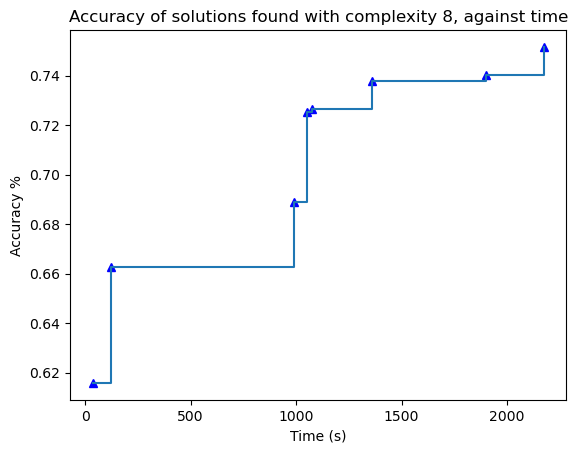

In [402]:
#tictactoe model performance
times = np.array([                     36,123,988,1051,1073,1358,1901,2174]) 
accrcies = np.array([i/958 for i in  [590,635,660, 695, 696, 707, 709, 720]]) 
  
plt.step(times, accrcies, 'b^', where='post') 
plt.step(times, accrcies, where='post')

plt.title("Accuracy of solutions found with complexity 8, against time")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy %")

plt.savefig('Performance_TicTac_alpha_8')
plt.show() 

In [ ]:
#heart disease model performance
times = np.array([                      2,  3, 19, 21, 22,137,194,195,225,283,    862,1028,1367,1542,1800]) 
accrcies = np.array([i/296 for i in  [159,177,180,207,208,224,226,228,230,236,    243, 245, 246, 247, 247]]) 
  
plt.step(times, accrcies, 'b^', where='post') 
plt.step(times, accrcies, where='post')

plt.title("Accuracy of solutions found with complexity 6, against time")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy %")

plt.savefig('Performance_alpha_6_30mins')
plt.show() 